In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from os.path import join
import re
import math
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL

# Coleta de Dados

In [152]:
MODULE_PATH = Path().absolute().parent
DATA_PATH = join(MODULE_PATH, "sources/processed")

In [153]:
complete_data = pd.read_csv(join(DATA_PATH, "selected_features_complete_df.csv"))

In [154]:
complete_data["data"] = pd.to_datetime(complete_data["data"])

In [155]:
complete_data = complete_data[complete_data.columns[:10].to_list()]

In [156]:
complete_data.head()

,ano,mes,data,precipitacao_total_media,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,umidade_rel_hora_media,categoria_El Ninõ,categoria_La Ninã,categoria_Neutro
0,2009,1,2009-01-01,0.149600,25.187439,20.299029,76.026835,0,1,0
1,2009,1,2009-01-02,0.305735,24.722086,20.084109,77.689743,0,1,0
2,2009,1,2009-01-03,0.434014,24.058518,19.749311,78.933681,0,1,0
3,2009,1,2009-01-04,0.245052,23.368056,18.715145,77.340627,0,1,0
4,2009,1,2009-01-05,0.201583,23.101135,17.945004,75.597683,0,1,0


# Definição de um Ground Truth

In [157]:
numerical_features = complete_data.columns.tolist()[3:-3]

In [158]:
for feature in numerical_features:
    feature_data = complete_data[feature]
    historical_mean = feature_data.mean()

    complete_data[f"{feature}_anomaly_value"] = feature_data - historical_mean
    complete_data[f"{feature}_anomaly_quartile"] = pd.qcut(complete_data[f"{feature}_anomaly_value"], q=4).astype(str)

In [159]:
complete_data.head()

,ano,mes,data,precipitacao_total_media,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,umidade_rel_hora_media,categoria_El Ninõ,categoria_La Ninã,categoria_Neutro,precipitacao_total_media_anomaly_value,precipitacao_total_media_anomaly_quartile,temperatura_bulbo_hora_media_anomaly_value,temperatura_bulbo_hora_media_anomaly_quartile,temperatura_orvalho_hora_media_anomaly_value,temperatura_orvalho_hora_media_anomaly_quartile,umidade_rel_hora_media_anomaly_value,umidade_rel_hora_media_anomaly_quartile
0,2009,1,2009-01-01,0.149600,25.187439,20.299029,76.026835,0,1,0,-0.019263,"(-0.0907, -0.0174]",1.602733,"(1.398, 4.596]",2.673260,"(2.181, 4.864]",3.465966,"(1.175, 4.361]"
1,2009,1,2009-01-02,0.305735,24.722086,20.084109,77.689743,0,1,0,0.136872,"(0.071, 0.584]",1.137380,"(0.46, 1.398]",2.458339,"(2.181, 4.864]",5.128873,"(4.361, 12.287]"
2,2009,1,2009-01-03,0.434014,24.058518,19.749311,78.933681,0,1,0,0.265151,"(0.071, 0.584]",0.473813,"(0.46, 1.398]",2.123542,"(0.579, 2.181]",6.372812,"(4.361, 12.287]"
3,2009,1,2009-01-04,0.245052,23.368056,18.715145,77.340627,0,1,0,0.076189,"(0.071, 0.584]",-0.216650,"(-1.335, 0.46]",1.089376,"(0.579, 2.181]",4.779758,"(4.361, 12.287]"
4,2009,1,2009-01-05,0.201583,23.101135,17.945004,75.597683,0,1,0,0.032720,"(-0.0174, 0.071]",-0.483571,"(-1.335, 0.46]",0.319235,"(-2.137, 0.579]",3.036813,"(1.175, 4.361]"


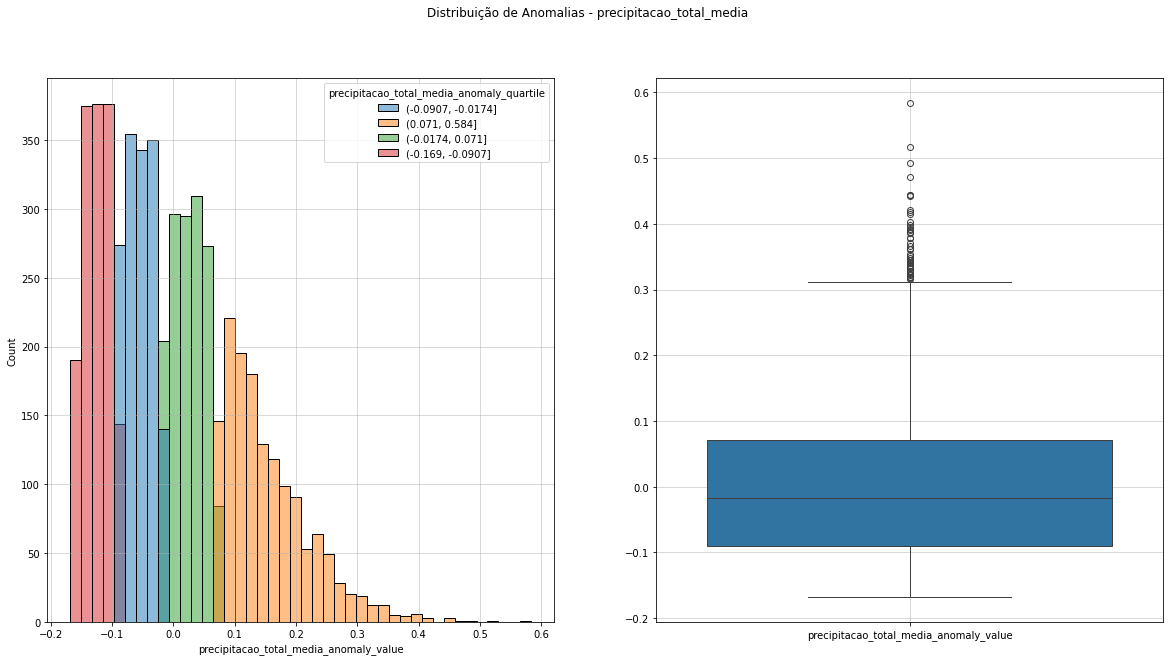

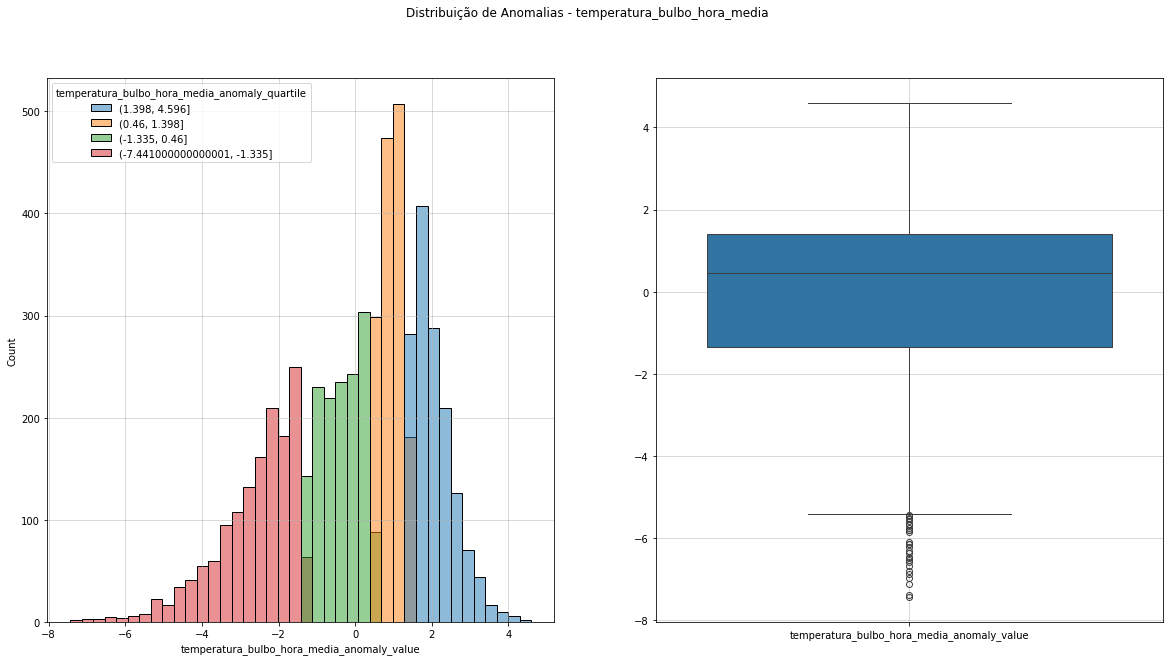

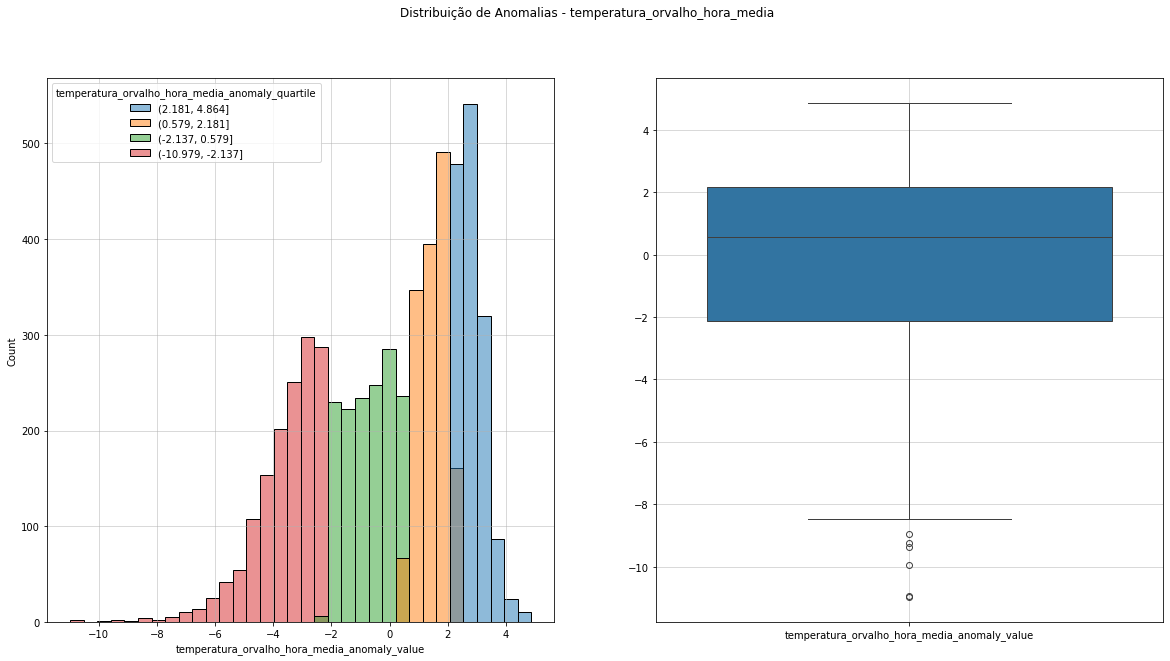

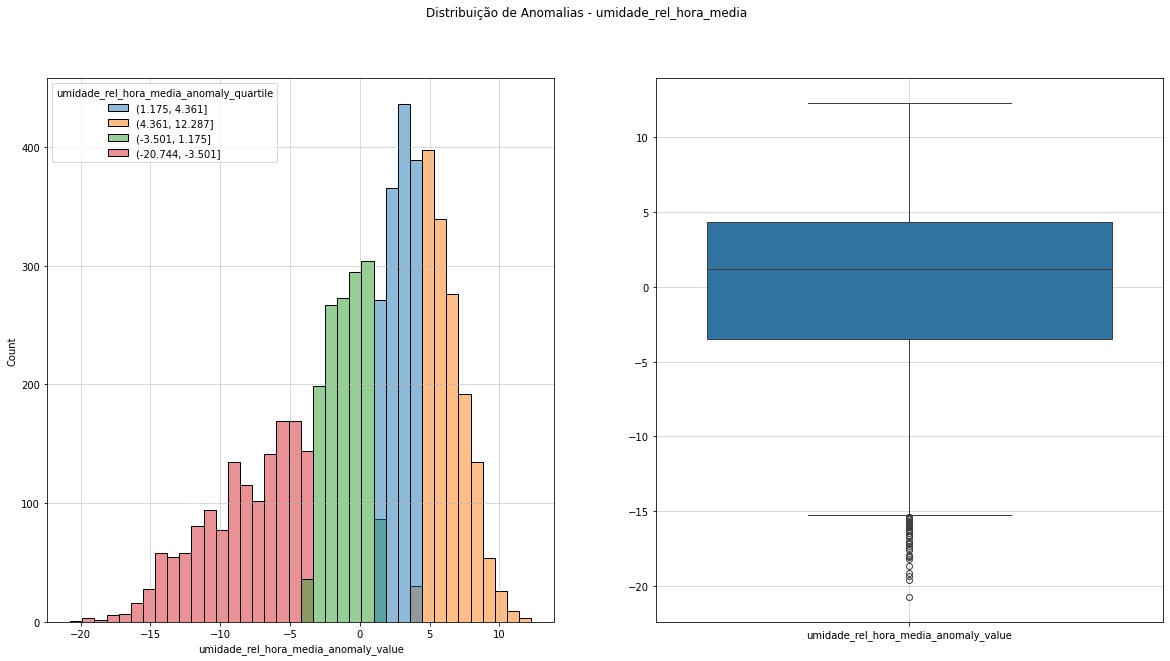

In [160]:
for feature in numerical_features:
    feature_anomaly_data = complete_data[[f"{feature}_anomaly_value", f"{feature}_anomaly_quartile"]]
    #feature_anomaly_quartiles = complete_data[f"{feature}_anomaly_quartile"].values
    # feature_anomaly_data_std = feature_anomaly_data / feature_anomaly_data.std()

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    sns.histplot(
        feature_anomaly_data, 
        x=f"{feature}_anomaly_value", 
        # kde=True, 
        hue=f"{feature}_anomaly_quartile", 
        ax=axes[0])
    sns.boxplot(feature_anomaly_data, ax=axes[1])
    plt.suptitle(f"Distribuição de Anomalias - {feature}")
    axes[0].grid(True, alpha=0.6)
    axes[1].grid(True, alpha=0.6)
    plt.show()

In [161]:
# precipitação: X > 0.3
# temperatura_bulbo: X < -5; X > 3
# temperatura_orvalho: X < -6; X > 3
# umidade: X < -15; X > 10

anomalies_map = {
    "precipitacao_total_media": 
        (complete_data["precipitacao_total_media_anomaly_value"] <= -0.15) |
        (complete_data["precipitacao_total_media_anomaly_value"] >= 0.2),
    "temperatura_bulbo_hora_media": 
            (complete_data["temperatura_bulbo_hora_media_anomaly_value"] <= -3) |
            (complete_data["temperatura_bulbo_hora_media_anomaly_value"] >= 2.75),
    "temperatura_orvalho_hora_media": 
            (complete_data["temperatura_orvalho_hora_media_anomaly_value"] <= -4.5) |
            (complete_data["temperatura_orvalho_hora_media_anomaly_value"] >= 3.5),
    "umidade_rel_hora_media": 
            (complete_data["umidade_rel_hora_media_anomaly_value"] <= -10) |
            (complete_data["umidade_rel_hora_media_anomaly_value"] >= 8)}

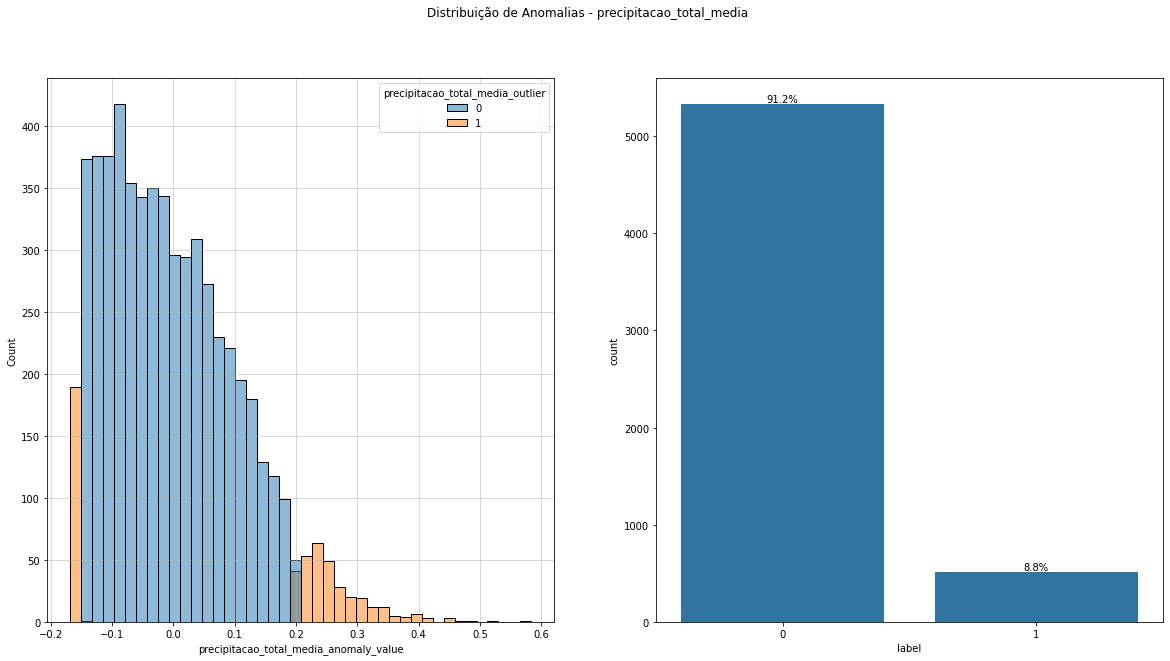

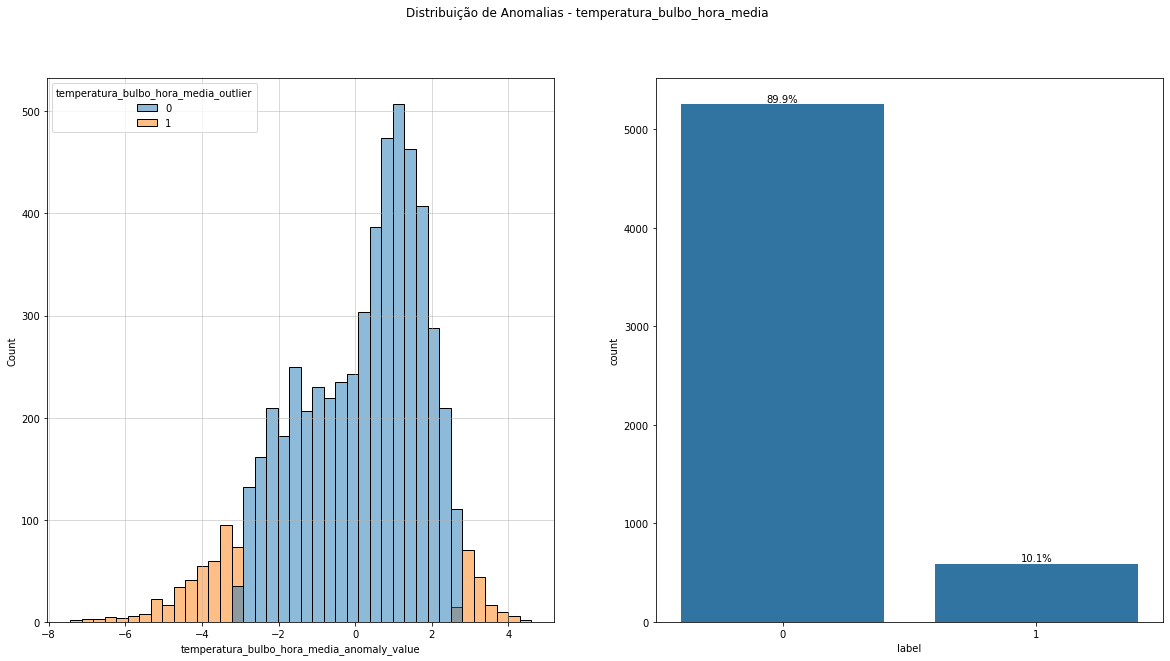

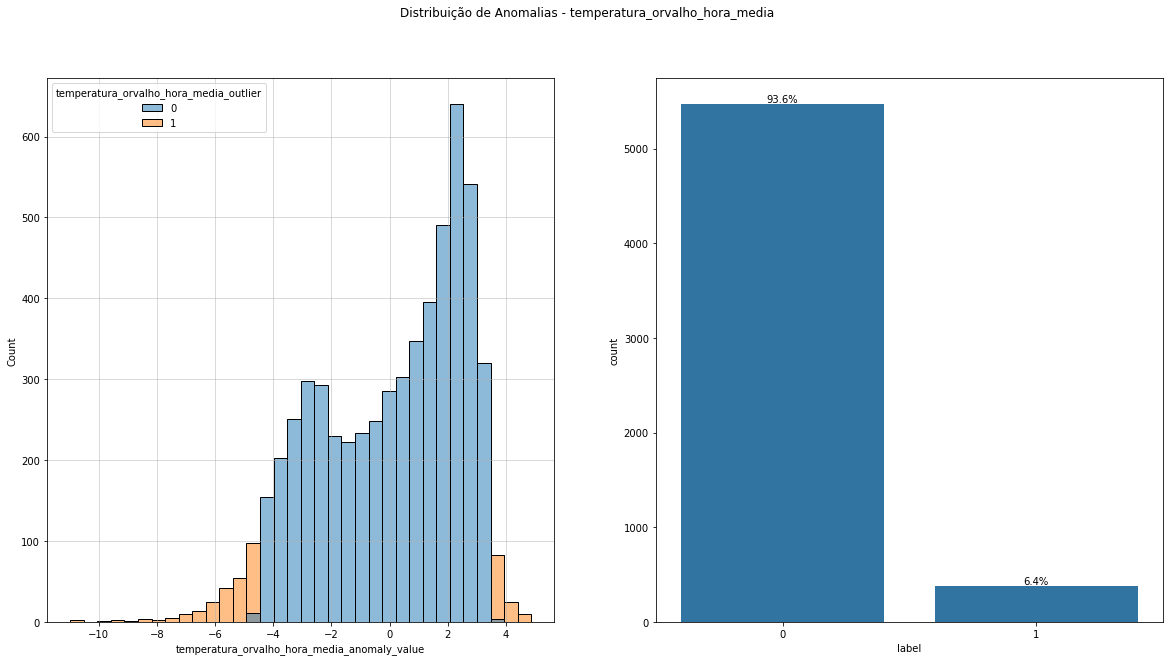

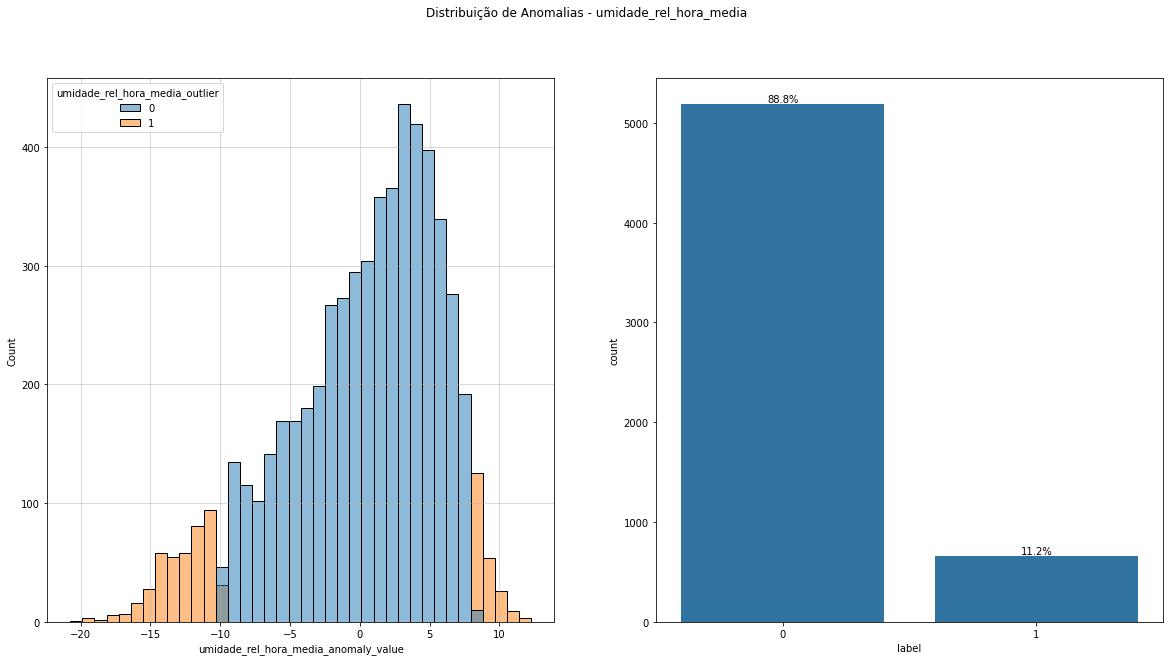

In [162]:
for feature, mask in anomalies_map.items():

    complete_data[f"{feature}_outlier"] = 0
    complete_data.loc[mask, f"{feature}_outlier"] = 1

    feature_anomaly_data = complete_data[[f"{feature}_anomaly_value", f"{feature}_outlier"]]
    counts = feature_anomaly_data[f"{feature}_outlier"].value_counts()
    percentages = counts / counts.sum() * 100

    counts_plot = counts.to_frame().reset_index()
    counts_plot.columns = ["label", "count"]

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    sns.histplot(
        feature_anomaly_data, 
        x=f"{feature}_anomaly_value", 
        hue=f"{feature}_outlier", 
        ax=axes[0])
    sns.barplot(counts_plot, x="label", y="count", ax=axes[1])
    for i, row in counts_plot.iterrows():
        axes[1].text(i, row['count'], f'{percentages[i]:.1f}%', ha='center', va='bottom')
    plt.suptitle(f"Distribuição de Anomalias - {feature}")
    axes[0].grid(True, alpha=0.6)
    plt.show()

# Visualização de Resultados

In [163]:
complete_data_ground_truth = complete_data[complete_data.columns.to_list()[:10] + complete_data.columns.to_list()[18:]]

In [164]:
complete_data_ground_truth.head()

,ano,mes,data,precipitacao_total_media,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,umidade_rel_hora_media,categoria_El Ninõ,categoria_La Ninã,categoria_Neutro,precipitacao_total_media_outlier,temperatura_bulbo_hora_media_outlier,temperatura_orvalho_hora_media_outlier,umidade_rel_hora_media_outlier
0,2009,1,2009-01-01,0.149600,25.187439,20.299029,76.026835,0,1,0,0,0,0,0
1,2009,1,2009-01-02,0.305735,24.722086,20.084109,77.689743,0,1,0,0,0,0,0
2,2009,1,2009-01-03,0.434014,24.058518,19.749311,78.933681,0,1,0,1,0,0,0
3,2009,1,2009-01-04,0.245052,23.368056,18.715145,77.340627,0,1,0,0,0,0,0
4,2009,1,2009-01-05,0.201583,23.101135,17.945004,75.597683,0,1,0,0,0,0,0


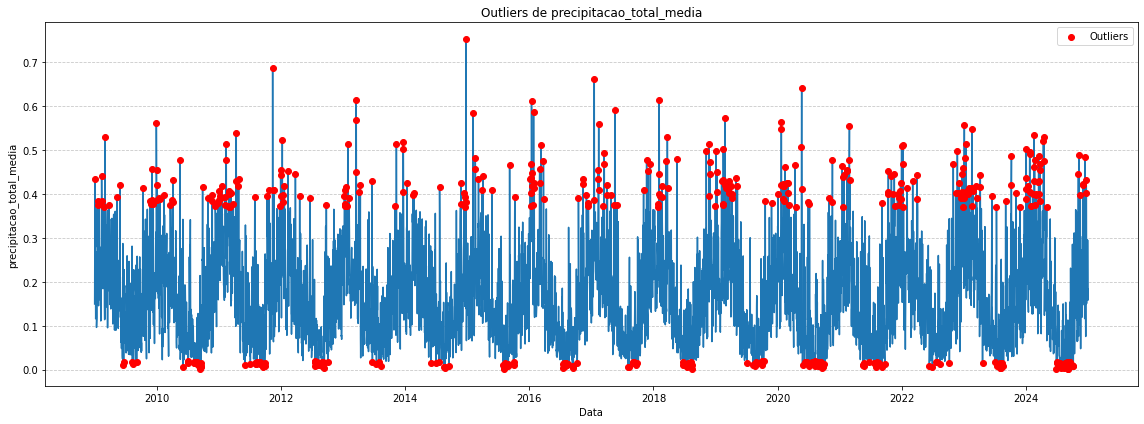

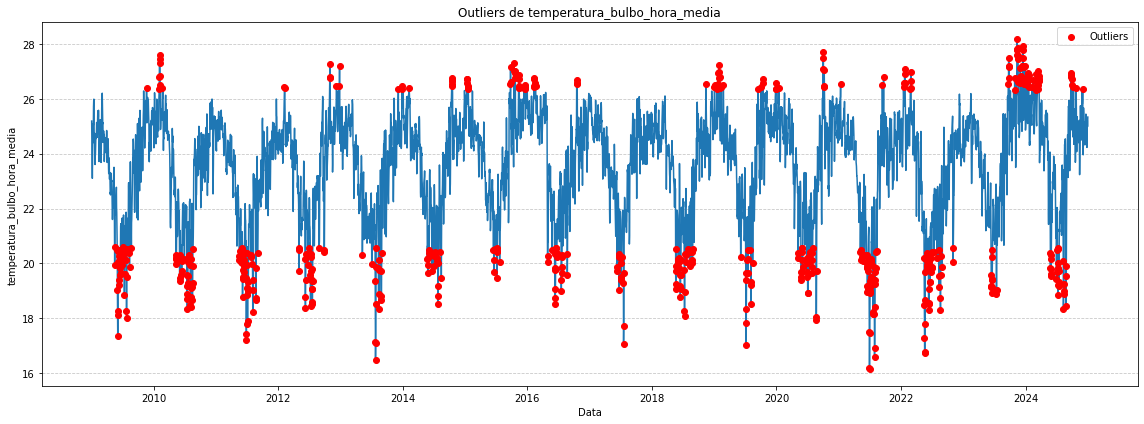

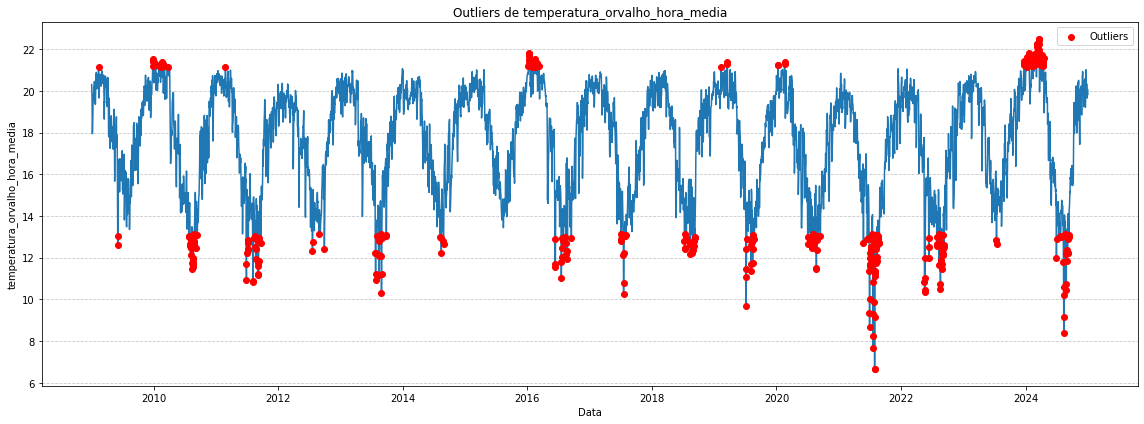

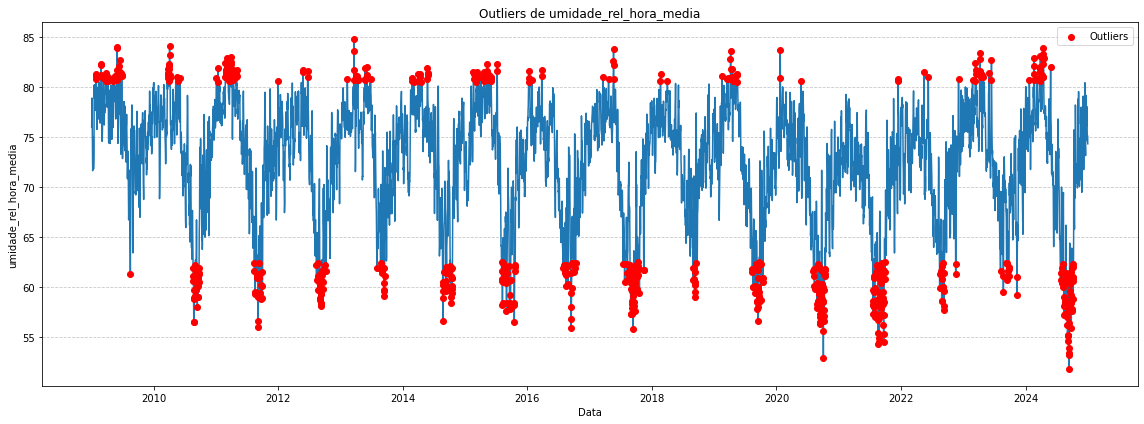

In [165]:
for feature in numerical_features:

    feature_data = complete_data[["data", feature]]
    feature_data = feature_data.set_index("data")

    feature_labels = complete_data[["data", f"{feature}_outlier"]]
    feature_labels = feature_labels.set_index("data")

    feature_outliers = feature_labels[feature_labels == 1].dropna().index

    plt.figure(figsize=(16, 6))
    plt.plot(feature_data.index, feature_data[feature])
    plt.scatter(
        feature_outliers, 
        feature_data.loc[feature_outliers], 
        color='red',
        label='Outliers',
        zorder=3)
    plt.title(f"Outliers de {feature}")
    plt.xlabel("Data")
    plt.ylabel(feature)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Exportação de Resultados

In [167]:
outlier_cols = [f"{feature}_outlier" for feature in numerical_features]
complete_data_ground_truth["total_outliers"] = complete_data_ground_truth[outlier_cols].sum(axis=1)

C:\Users\testd\AppData\Local\Temp\ipykernel_13204\3018992779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_data_ground_truth["total_outliers"] = complete_data_ground_truth[outlier_cols].sum(axis=1)


In [170]:
complete_data_ground_truth.to_csv(join(DATA_PATH, "complete_data_ground_truth.csv"), index=False)